In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement_df = Base.classes.measurement 
station_df = Base.classes.station 

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
def temp(start):
    session = Session(engine)
    min_temp = session.query(func.min(measurement_df.tobs)).filter(measurement_df.date >= start).all()
    max_temp = session.query(func.max(measurement_df.tobs)).filter(measurement_df.date >= start).all()
    avg_temp = session.query(func.avg(measurement_df.tobs)).filter(measurement_df.date >= start).all()

    session.close()
    return {"cl":min_temp, "lc":max_temp, "lu":avg_temp}
    

In [10]:
temp(f"2010-02-28")

{'cl': [(53.0,)], 'lc': [(87.0,)], 'lu': [(73.18960212754862,)]}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(measurement_df.date).\
    order_by(measurement_df.date.desc()).first()
                      
recent_date

('2017-08-23',)

<AxesSubplot:xlabel='Date', ylabel='Inches'>

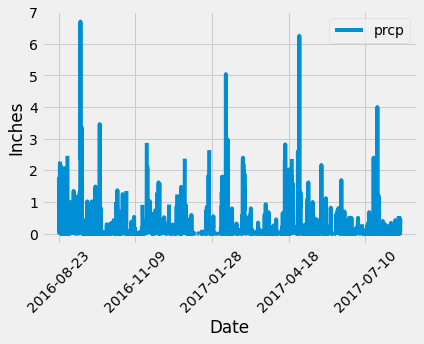

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_12_mo =  dt.date(2017,8,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation_score = session.query(measurement_df.date, measurement_df.prcp).\
        filter(func.strftime('%Y-%m-%d', measurement_df.date) >= last_12_mo).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation_score)
prcp_df.columns= ['date', 'prcp']
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df.sort_values('date',inplace=True, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind = 'line', y='prcp', xlabel= 'Date', ylabel='Inches', rot=45)



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station_df).count()
station_count

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement_df.station, func.count(measurement_df.station)).\
        group_by(measurement_df.station).\
        order_by(func.count(measurement_df.station).desc()).all()

active_stations

#We are getting the unique count of each station, if we took out group by it would count the entire dataset and only give us total of rows



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stations_temp = session.query(func.min(measurement_df.tobs),
        func.max(measurement_df.tobs),
        func.avg(measurement_df.tobs)).\
        filter((measurement_df.station) == 'USC00519281').all()
active_stations_temp

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

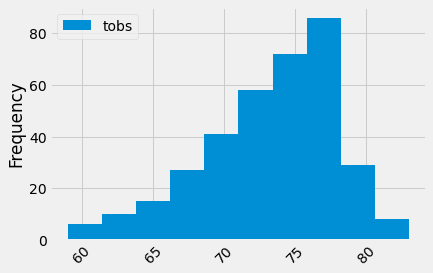

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_data = session.query(measurement_df.date, measurement_df.tobs).\
    filter(measurement_df.date >= last_12_mo).\
    filter(measurement_df.station == 'USC00519281').all()

active_station_df = pd.DataFrame(most_active_station_data)

active_station_df.columns= ['date', 'tobs']
active_station_df = active_station_df.set_index(['date'])

# Sort the dataframe by date
active_station_df.sort_values('date',inplace=True, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
active_station_df.plot(kind = 'hist', y='tobs', ylabel='Frequency', rot=45)




# Close session

In [18]:
# Close Session
session.close()